# ML Model training

This is the fourth notebook in a series on creating propensity models with datasets from AEP.
In this notebook, we train an ML model to predict propensity of subscription, using previously featurized data that has been "exported" from AEP. 

This notebook is step 4 in the diagram below.

![exploration](../media/CME-PoC-MLTraining.png)

<div class="alert alert-warning">
    <em> This section contains issues that crop up</em>
    <ul>
        <li> Item 1.</li>
    </ul>
    
</div>


## Ingesting Training Data
In this section, we will load our training data, and create train test splits. Note that because the initial exploration dataset is small, we can either query and load the entire dataset into memory, or we can load it directly from the exported AEP dataset. 

We will keep our implementation modular, so that either "direct query service call", or "load from blob storage" is an option. 

### Training Data from Query Service

In [1]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def get_result_as_df(cur):
    data = [r for r in cur]
    colnames = [desc[0] for desc in cur.description]
    return pd.DataFrame(data, columns=colnames)



In [7]:
# IGNORE CODE BELOW - you can use it if you'd like, but instead we'll read from Blob storage

# conn = psycopg2.connect("sslmode=require host=targetpremiumqa2.platform-query-stage.adobe.io port=80 dbname=prod:all user=039E5CD253BE29E30A4C86E6@AdobeOrg password=eNqrVkrMSVeyUgoKNjI1U9JRqjAtBfIyc4vj8xINdYtL0g11s1MrdRNLdA31klOLgCqyM1NwqQDKZpaUAGUTS5RqAcSwGzc=.eNqNU11vmzAU_S88AzEfsSHSpLGm0VKFdE0_UlAkZGxDnQSMsNMkrfrfZyftNrUv84vNuedcX99zebU4tUaWByGMYogQisGwKMsKBcBHTkARcsIoRE4JQemgkvrIQ1UUerTY7X3LttSxY1qPCWFSFkpsWKtRsuWsVcUpNTuQAnedRneS9WcsQAjCwJ-EQzQBURTGsQ8mSTL5nlBRsulYk6XCymR-XVlSp-aiXVmjlfWkVCdHgwFvpNNiz5Gq9lxsVFtR89YlojGxwbtm8OwNsvXD5nqceundVGXL9JBeAJA3qT-72z7lBmuuNvlywjN_us-XWTi7BS_zF-LP1-lxsb7x5iDbX49rcH23OaaX-Y-b-zy5WS6es-bhapGsrDddLZa61H9rMhj-78cS1VkjYFtVrfnL8D7NHqeXjwv4mMDxLLjI08SfJj-zb6dlmvPXtGA4RCBEYTEEcQiHXuwEPgROCGLolFUVOYgFCJc6Gmhnz6Y1gms5QYhV1As00JVYAymjt4zMxeWDPRN7fdQRduh4z2TBW02IYAjMMhUQcTa-dBvc4prZmFKudMvxVpMr8fnbXYuyqHYtMdiXYNeLNSOK0V-9oDuiLkSr2EF94fViy6T93jj75DsXrh6vntVcqv7o9gzTj4CeO27jHdXDSNi5zP6EEc1S_JkVZCt21G46aevntJzaRl6IvsYtf8HmZnmGOvKxu5h0f860wYXCvcKt_T5xxk2TndECq89_lvX2G4C2Gq4=.eNoBAAH__l-z335lSznVOdKxa16E5V1P-NP0xvbzttbB8rmRrAHlKQOpXyr9jaHirWWONkWiAutGtrQIp3hsBfMmBhvCjDAButRM6SrIAmlK9F9kdGeLtsRRoOQfEN1Cn9dx-ee76Dp8bo_MSs_gM8T3kDwFeNckSZ7O3OrsZCTyURBxIPKzAoPJTErdeEKZCiZ1P7qF9xzF6rR1nU34nhv7amzo_NImXqp8eER6KNaAK3uV5aeSs3hDirh413jmlSjK839_JbsFGsWZPaW7S_o__CCCOSjqhxoQQxBt1oS72enAfPnLRKrqGJ1As59cMSRBQ0FpyH7VTMUetMOU43gpJoJ0VMHPjYae")

# cur = conn.cursor()
# cur.execute('''
#     SELECT * FROM featurized_subscription_propensity_dataset LIMIT 10
# ''')
# df = get_result_as_df(cur)

## Read featurized data from blob storage 

We have been able to successfully configure exports to the "data landing zone" - A customer specific azure blob storage account. 
Connection to this can be done via a Secure Access Signature (SAS) token, that is available via API from Experience Platform.

In [5]:
# TODO: Code to retrieve the SAS token from AEP
from azure.storage.blob import ContainerClient
import pandas as pd


#NOTE - data in the data landing zone is deleted after 7 days. 
# - therefore for repeatability, the following code points to our own azure blob. 

LOCALFILENAME = "data/featurized_data_new.parquet"

BLOB_DOWNLOAD_SAS_URL = "SECRETS"
BLOBNAME = "featurized-10k-users/10kusers_featurized.parquet"

container_client = ContainerClient.from_container_url(BLOB_DOWNLOAD_SAS_URL)
with open(LOCALFILENAME, "wb") as download_file:
    download_file.write(container_client.download_blob(BLOBNAME).readall())
 
#Read the data back into pandas
df = pd.read_parquet(LOCALFILENAME)

### Describe the data

In [6]:
print(list(df.columns))
df.describe()

['userId', 'eventType', 'timestamp', 'subscriptionOccurred', 'emailsReceived', 'emailsOpened', 'emailsClicked', 'productsViewed', 'propositionInteracts', 'propositionDismissed', 'webLinkClicks', 'minutes_since_emailSent', 'minutes_since_emailOpened', 'minutes_since_emailClick', 'minutes_since_productView', 'minutes_since_propositionInteract', 'minutes_since_propositionDismiss', 'minutes_since_linkClick', 'random_row_number_for_user']


,subscriptionOccurred,emailsReceived,emailsOpened,emailsClicked,productsViewed,propositionInteracts,propositionDismissed,webLinkClicks,minutes_since_emailSent,minutes_since_emailOpened,minutes_since_emailClick,minutes_since_productView,minutes_since_propositionInteract,minutes_since_linkClick,random_row_number_for_user
count,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9470.000000,5520.000000,2172.000000,1223.000000,114.000000,1327.000000,9991.000000
mean,0.151036,2.963167,1.087779,0.262336,0.149434,0.012011,0.009609,0.162046,3817.878881,13527.705254,8227.166667,17385.743254,12169.359649,16471.543331,2.015214
std,0.358102,2.018841,1.289521,0.546297,0.433102,0.114319,0.102559,0.450186,9265.638447,21783.384867,18522.576785,24031.018401,22744.109005,24353.042024,2.964179
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000
50%,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,224.500000,50.000000,10.000000,1468.000000,1.000000,55.000000,1.000000
75%,0.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2266.750000,22304.250000,1605.500000,30710.000000,11554.250000,28604.500000,1.000000
max,1.000000,12.000000,9.000000,5.000000,4.000000,2.000000,2.000000,4.000000,87148.000000,96578.000000,95901.000000,97309.000000,92184.000000,100060.000000,25.000000


### ML Model training

In this section, we will do the actual ML model training.

We do the following steps:

1. Create a train-test split
2. Instantiate a Gradient Boosted Tree classifier and a RandomForestClassifier
3. Train the models and evaluate on a test set. 

### ML Model training

In [7]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
    
# Feature Selection
features = ['emailsReceived', 'emailsOpened', 'emailsClicked', 
            'productsViewed', 
            'propositionInteracts', 'propositionDismissed', 'webLinkClicks', 
            'minutes_since_emailSent', 'minutes_since_emailOpened', 'minutes_since_emailClick', 
            'minutes_since_productView', 'minutes_since_propositionInteract', 
            'minutes_since_propositionDismiss', 'minutes_since_linkClick']
X, y = df[features].fillna(0), df["subscriptionOccurred"]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)


# Model training
gb_clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, 
                                    max_depth=2, random_state=0).fit(X_train, y_train)
rf_clf = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)


# Model evaluation
print("---Accuracies---")
print("Gradient Boosted Tree (GBT):", gb_clf.score(X_test, y_test))
print("Random Forest (RF):", rf_clf.score(X_test, y_test))

print("")

print("---AUC Scores---")
print("GBT: ", roc_auc_score(y_test, gb_clf.predict_proba(X_test)[:, 1]))
print("RF: ", roc_auc_score(y_test, rf_clf.predict_proba(X_test)[:, 1]))

---Accuracies---
Gradient Boosted Tree (GBT): 0.9281871637682972
Random Forest (RF): 0.9189290629300638

---AUC Scores---
GBT:  0.9527478150894984
RF:  0.9419291422528123


# Hyperparmeter tuning
Let's tune the number of estimators used in the random forest

In [8]:
from sklearn.model_selection import GridSearchCV

#The base estimator
gb_clf = RandomForestClassifier()

n_estimators = [2,3,4,5,10,15,20,30,40,50]
parameters = {'n_estimators': n_estimators}
clf = GridSearchCV(gb_clf, parameters, cv=5, scoring = ["accuracy", "precision", "recall", "f1", "roc_auc"], refit=False)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

**Visualize the results**

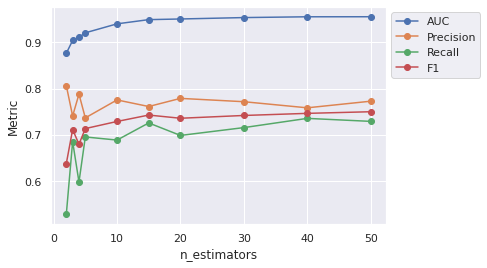

In [9]:
import seaborn as sns

results = clf.cv_results_
params = clf

sns.set()
fig, ax = plt.subplots()
ax.plot(n_estimators, results['mean_test_roc_auc'], "o-", label="AUC")
ax.plot(n_estimators, results['mean_test_precision'], "o-", label="Precision")
ax.plot(n_estimators, results['mean_test_recall'], "o-", label="Recall")
ax.plot(n_estimators, results['mean_test_f1'], "o-", label="F1")
ax.set_xlabel("n_estimators")
ax.set_ylabel("Metric")
plt.legend(bbox_to_anchor=(1,1))

## Make predictions for everyone in the training set

This data setup is a bit unconventonal - we have done model tuning on an appropriate train/test split but now we must make predictions for everyone in the population. In a more regular setup, we would probably have training and testing data as a small fraction of the total amount of data

In [10]:
final_classifier = RandomForestClassifier(n_estimators = 20).fit(X, y)
final_predictions = final_classifier.predict_proba(X)

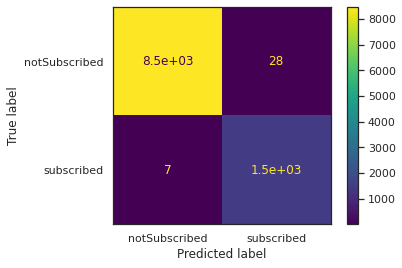

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


sns.set_style("white")
ConfusionMatrixDisplay(confusion_matrix(final_classifier.predict(X), y), display_labels=["notSubscribed", "subscribed"]).plot()

## Compute a reach graph

Text(0, 0.5, 'Fraction of Population in Segment')

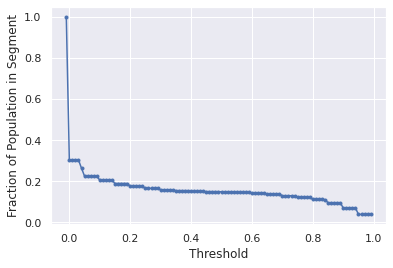

In [12]:
def reach(threshold, predictions):
    return sum(predictions[:,1] > threshold)/len(predictions)

thresholds = [x/100 for x in range(-1, 100)]
reaches = [reach(threshold, final_predictions) for threshold in thresholds]
sns.set()


fig, ax = plt.subplots()
ax.plot(thresholds, reaches, ".-")
ax.set_xlabel("Threshold")
ax.set_ylabel("Fraction of Population in Segment")

# Create the dataset for export

In [13]:
df["propensityForSubscription"] = final_predictions[:,1]
df[["userId", "subscriptionOccurred", "propensityForSubscription"]]

,userId,subscriptionOccurred,propensityForSubscription
0,39145476318678571307594208058693720076,0,0.000000
1,84486904098823785418719322404578241180,0,0.000000
2,36132345067467872908222618458457485058,0,0.036371
3,34533795589432174096553638143627506038,0,0.000000
4,10263326322014847784303593261657963576,0,0.036371
...,...,...,...
9986,09357483895364560233762927357279822076,0,0.050000
9987,35271372595072375170234978238335187588,0,0.050000
9988,68219486189160749412155414367324739091,1,0.800000
9989,44461508129005693500345915359390710528,0,0.000000


## Write Data to a temporary "local" file
This seems to be the only way I know to write data to blob storage. First write it to a local file. 

In [16]:
import json 

out_data = df[["userId", "propensityForSubscription"]].to_dict(orient='records')

dict_out_data = [{"personID": d["userId"], "_targetpremiumqa6": {"subscriptionPropensity": d["propensityForSubscription"]}} for d in out_data]

json_data = [json.dumps(row) for row in dict_out_data]

with open("data/output_test.json", "w") as f:
    f.write("\n".join(json_data))

#### And now write it to blob storage. 
This is the URL of the data landing zone, obtained by creating a "Data Landing Zone" source. 

In [18]:
from azure.storage.blob import ContainerClient
from datetime import datetime

sas_url = "SECRETS"
dlz_sas_url = 'SECRETS'
container = ContainerClient.from_container_url(dlz_sas_url)

now_str = datetime.now().isoformat()
with open("data/output_test.json", "rb") as data:
    container.upload_blob(name=f"propensities/subscription-propensity-data-v1-{now_str}.json", data=data)

### Importing the data to a dataset on AEP

We now need to go the AEP UI, and configure the "Source" dataflow, to use this file in the data landing zone, and import data into our desired dataset. 